In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import pystan
import scipy
import sys
sys.path.append("..")
import bayesian_anova

Using gpu device 1: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [3]:
cols = ['test_acc',
        'train_time',
        'entropy__bal_acc', 
        'entropy__auc']

In [4]:
experiments = ['convolutional', 'convolutional-dropout', 'convolutional-poor-bayesian']

In [5]:
dfs = []
for exp in experiments:
    df_with = pd.read_csv(exp+'_with_unknown.csv')
    df_with_results = df_with.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    df_without = pd.read_csv(exp+'_out_unknown.csv')
    df_without_results = df_without.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    dfs.append([exp, df_with_results, df_without_results])

In [6]:
results_cols = ['inside', 'outside',
                'in_test_acc', 'out_test_acc',
                'in_train_time', 'out_train_time',
                'in_entropy_acc', 'out_entropy_acc',
                'in_entropy_auc', 'out_entropy_auc']

dfs_results = []
for exp, df_with, df_without in dfs:
    results = pd.DataFrame(columns=results_cols)
    for (in_key, *in_row), (out_key, *out_row) in zip(df_with.itertuples(), df_without.itertuples()):
        assert in_key == out_key
        results.loc[len(results)] = [
            in_key[0], in_key[1],
            in_row[0], out_row[0],
            in_row[1], out_row[1],
            in_row[2], out_row[2],
            in_row[3], out_row[3],
        ]
    dfs_results.append([exp, results])

In [7]:
final_results_cols = ['inside', 'outside']
for c in results_cols[2:]:
    for exp, _ in dfs_results:
        final_results_cols.append(exp+'_'+c)

In [8]:
final_results = pd.DataFrame(columns=final_results_cols)
for key_row  in zip(*[df.itertuples() for exp, df in dfs_results]):
    for i in range(1, len(key_row)):
        _, *prev_row = key_row[i-1]
        _, *row = key_row[i]
        assert prev_row[0] == row[0]
        assert prev_row[1] == row[1]
        
    _, *row = key_row[0]
    new_row = [row[0], row[1]]
    
    for c in range(2, len(results_cols)):
        for _, *row in key_row:
            new_row.append(row[c])

    final_results.loc[len(final_results)] = new_row

In [9]:
final_results.columns

Index(['inside', 'outside', 'convolutional_in_test_acc',
       'convolutional-dropout_in_test_acc',
       'convolutional-poor-bayesian_in_test_acc', 'convolutional_out_test_acc',
       'convolutional-dropout_out_test_acc',
       'convolutional-poor-bayesian_out_test_acc',
       'convolutional_in_train_time', 'convolutional-dropout_in_train_time',
       'convolutional-poor-bayesian_in_train_time',
       'convolutional_out_train_time', 'convolutional-dropout_out_train_time',
       'convolutional-poor-bayesian_out_train_time',
       'convolutional_in_entropy_acc', 'convolutional-dropout_in_entropy_acc',
       'convolutional-poor-bayesian_in_entropy_acc',
       'convolutional_out_entropy_acc',
       'convolutional-dropout_out_entropy_acc',
       'convolutional-poor-bayesian_out_entropy_acc',
       'convolutional_in_entropy_auc', 'convolutional-dropout_in_entropy_auc',
       'convolutional-poor-bayesian_in_entropy_auc',
       'convolutional_out_entropy_auc',
       'convolut

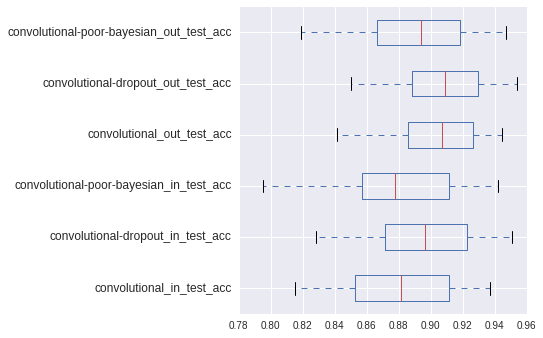

In [10]:
plt.figure()
plt.rcParams['figure.figsize'] = (10, 15)
final_results.boxplot(return_type='axes', vert=False, column=list(final_results.columns)[2:8])
plt.subplots_adjust(left=0.4)

In [11]:
model = pystan.StanModel(model_code=bayesian_anova.one_way_code)

In [12]:
out_acc = ['convolutional_out_entropy_auc', 'convolutional-dropout_out_entropy_auc', 'convolutional-poor-bayesian_out_entropy_auc']
y_out = final_results[out_acc].values
y_out = scipy.special.logit(y_out)

in_acc = ['convolutional_in_entropy_auc', 'convolutional-dropout_in_entropy_auc', 'convolutional-poor-bayesian_in_entropy_auc']
y_in = final_results[in_acc].values
y_in = scipy.special.logit(y_in)

/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction

Inference for Stan model: anon_model_1967665b99160b0ba8694ab613d646dd.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 1.34  8.3e-4   0.05   1.24   1.31   1.34   1.38   1.44   4000    1.0
theta_free[0]    4.7e-3  8.5e-4   0.05  -0.11  -0.02 3.2e-3   0.03   0.12   4000    1.0
theta_free[1]      0.02  8.6e-4   0.05  -0.08-7.7e-3   0.01   0.05   0.15   4000    1.0
sigma_likelihood   0.41  6.1e-4   0.04   0.34   0.38    0.4   0.43   0.49   4000    1.0
sigma_theta        0.34    0.03   1.85 6.6e-3   0.03   0.08   0.19   2.05   4000    1.0
theta[0]         4.7e-3  8.5e-4   0.05  -0.11  -0.02 3.2e-3   0.03   0.12   4000    1.0
theta[1]           0.02  8.6e-4   0.05  -0.08-7.7e-3   0.01   0.05   0.15   4000    1.0
theta[2]          -0.03  9.6e-4   0.06  -0.16  -0.06  -0.02 9.8e-3   0.09   4000    1.0
lp__              

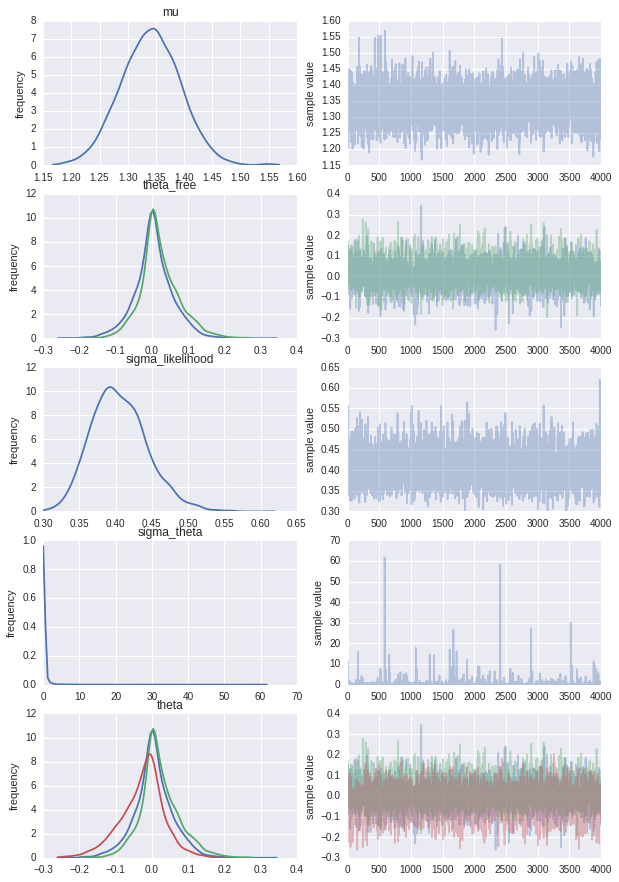

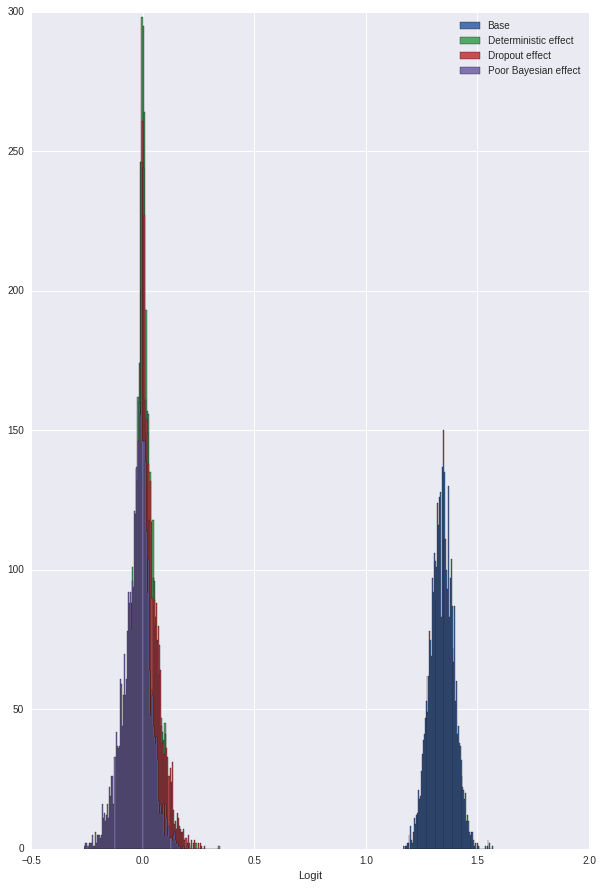

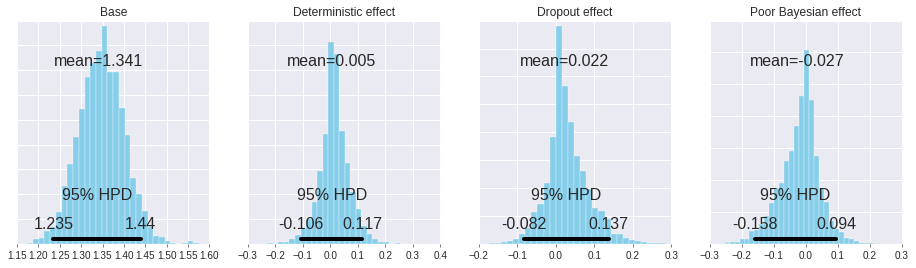

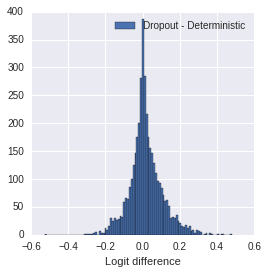

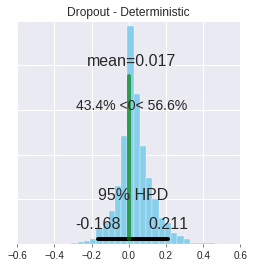

Dropout - Deterministic 95.0 CI: -0.162958833909 0.226996410004 Pr > 0: 0.566


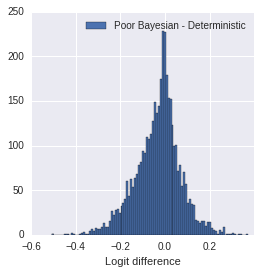

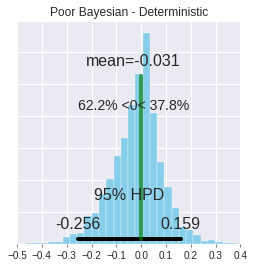

Poor Bayesian - Deterministic 95.0 CI: -0.247719560261 0.167716847201 Pr > 0: 0.378


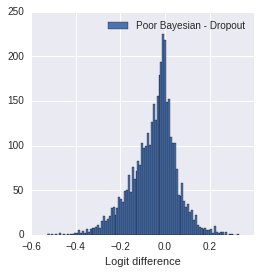

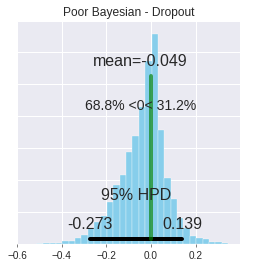

Poor Bayesian - Dropout 95.0 CI: -0.275913579913 0.137782930049 Pr > 0: 0.3125


/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction

Inference for Stan model: anon_model_1967665b99160b0ba8694ab613d646dd.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 1.03  5.3e-4   0.03   0.96    1.0   1.03   1.05   1.09   4000    1.0
theta_free[0]     -0.02  6.0e-4   0.04  -0.11  -0.05  -0.01 3.0e-3   0.04   4000    1.0
theta_free[1]      0.03  6.4e-4   0.04  -0.03 1.6e-3   0.02   0.06   0.12   4000    1.0
sigma_likelihood   0.25  3.7e-4   0.02   0.21   0.24   0.25   0.27    0.3   4000    1.0
sigma_theta        0.24    0.02   0.99 4.6e-3   0.03   0.06   0.15   1.25   4000    1.0
theta[0]          -0.02  6.0e-4   0.04  -0.11  -0.05  -0.01 3.0e-3   0.04   4000    1.0
theta[1]           0.03  6.4e-4   0.04  -0.03 1.6e-3   0.02   0.06   0.12   4000    1.0
theta[2]        -8.5e-3  6.1e-4   0.04  -0.09  -0.03-6.3e-3   0.01   0.07   4000    1.0
lp__              

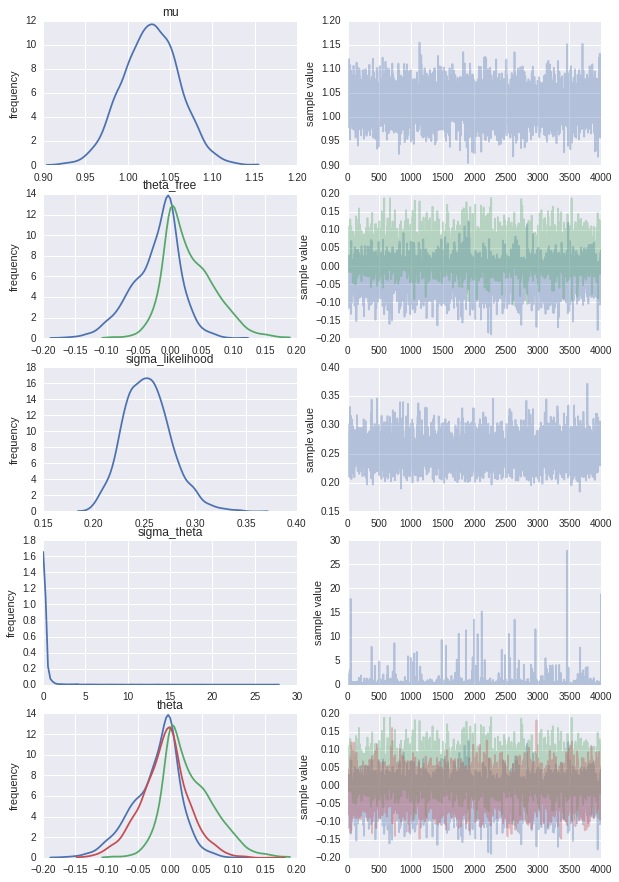

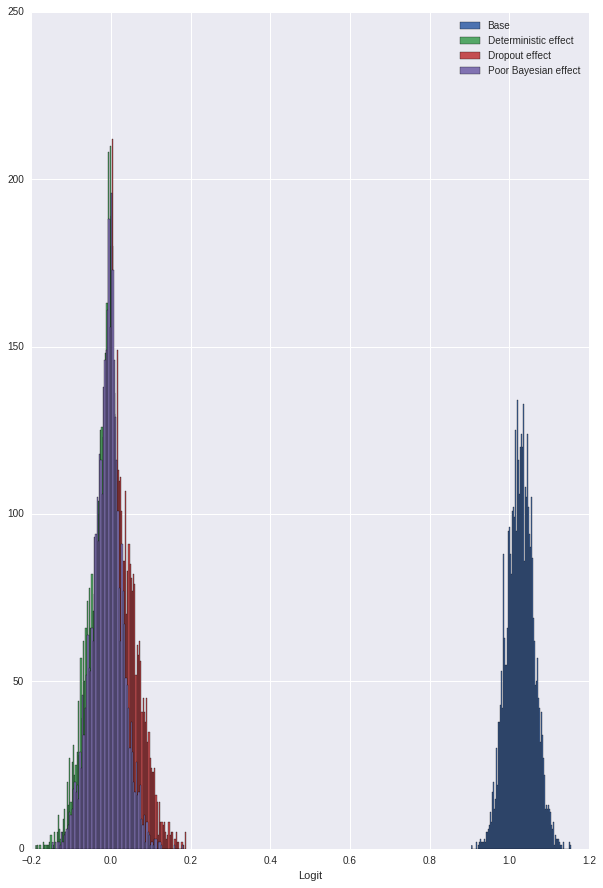

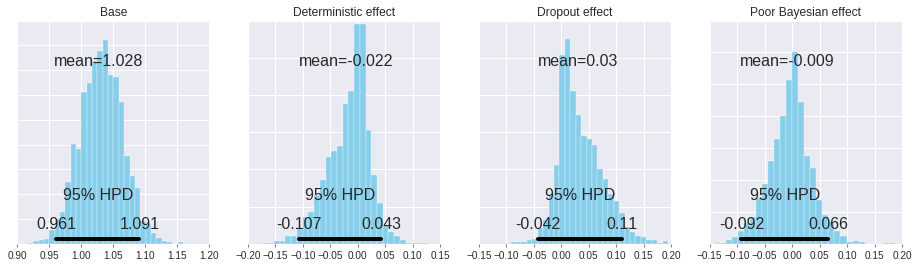

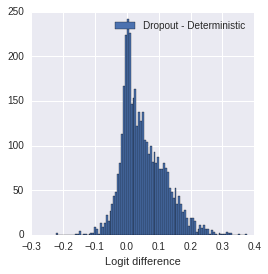

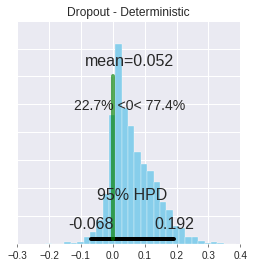

Dropout - Deterministic 95.0 CI: -0.0555703462753 0.207102262534 Pr > 0: 0.7735


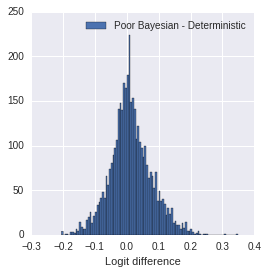

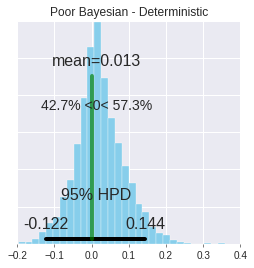

Poor Bayesian - Deterministic 95.0 CI: -0.11565062063 0.151884533655 Pr > 0: 0.57275


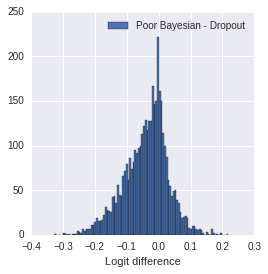

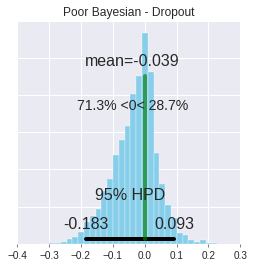

Poor Bayesian - Dropout 95.0 CI: -0.191038808597 0.0862769203375 Pr > 0: 0.287


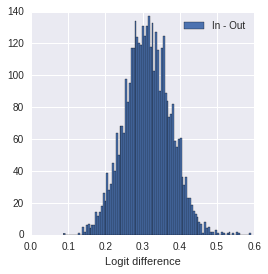

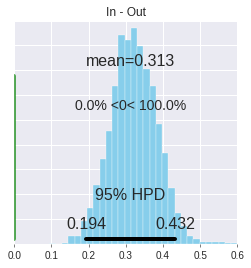

In - Out 95.0 CI: 0.19376020384 0.432574890524 Pr > 0: 1.0


In [13]:
for y in [y_in, y_out]:
    (N, K) = y.shape

    data = {'K': K, 'N': N, 'y': y}
    fit = model.sampling(data=data, iter=10000, chains=4, thin=5)
    
    bayesian_anova.show_results(fit)
    
    trace = fit.extract()
    deterministic = trace['theta'][:,0]
    dropout = trace['theta'][:,1]
    poor_bayesian = trace['theta'][:,2]
    base_mean = trace['mu']
    
    if y is y_in:
        in_mean = np.copy(base_mean)
    else:
        out_mean = np.copy(base_mean)

    bayesian_anova.plot_traces([base_mean, deterministic, dropout, poor_bayesian],
                               ["Base", "Deterministic effect", "Dropout effect", "Poor Bayesian effect"])

    bayesian_anova.effect_difference(dropout, deterministic, 'Dropout', 'Deterministic')
    bayesian_anova.effect_difference(poor_bayesian, deterministic, 'Poor Bayesian', 'Deterministic')
    bayesian_anova.effect_difference(poor_bayesian, dropout, 'Poor Bayesian', 'Dropout')

bayesian_anova.effect_difference(in_mean, out_mean, 'In', 'Out')